### Comparison of bulk to single-cell RPS2-STAMP data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
from collections import OrderedDict, defaultdict
import seaborn as sns
import pandas as pd
import numpy as np
import os
import glob
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

In [2]:
# Single-cell files
scRPS2_barcode = '/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/sailor_outputs_groups_deep/combined_outputs_w_cov_info/RPS2-STAMP_possorted_genome_bam_MD-RPS2_non_APO_edits_barcodes_RPKM.txt.fx.annotated'

In [3]:
# Bulk RPS2 annotated file
annotated_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info/'
RPS2_1000_bulk_file = 'RPS2-1000_S18_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted_a0_b0_e0.01.annotated'

RPS2_1000_bulk = os.path.join(annotated_dir, RPS2_1000_bulk_file)

In [4]:
# All counts and length files for single-cell processing
ribo_dir = '/home/rmarina/projects/apobec/revision_riboseq_comparison/ribosome_files/'
counts_dir = '/home/rmarina/projects/apobec/revision_riboseq_comparison/featurecounts/for_singlecell/'
output_dir = '/home/rmarina/projects/apobec/revision_riboseq_comparison/outputs/epkm_reconstruct/epkm_all_samples/'

sc_cds_3utr_gene_counts = pd.read_csv(os.path.join(counts_dir, 'sc_rps2_cluster_counts.cds_and_3utr.txt'), comment='#', sep='\t', index_col=0).drop(['Chr','Start','End','Strand'], axis=1)
sc_cds_gene_counts = pd.read_csv(os.path.join(counts_dir, 'sc_rps2_cluster_counts.cds_only.txt'), sep='\t', comment='#', index_col=0).drop(['Chr','Start','End','Strand'], axis=1)

cds_gene_length = pd.read_csv(os.path.join(ribo_dir, 'cds_lengths_renamed.txt'), sep='\t', index_col=0)
cds_3utr_gene_length = pd.DataFrame(sc_cds_3utr_gene_counts.Length)
all_gene_length = pd.read_csv(os.path.join(ribo_dir, 'geneid_lengths.txt'), sep='\t', index_col=0)

# Was missing this part from last time since I only had whole gene length and 
cds_utr_bulk_counts = pd.read_csv('/home/bay001/projects/kris_apobec_20200121/permanent_data/20191003_riboseq/featurecounts/counts.cds_and_3utr.txt',
                                  sep='\t', comment='#', index_col=0).drop(['Chr','Start','End','Strand'], axis=1)

In [5]:
# Rename the CDS/3UTR counts for bulk 
rename_dict = defaultdict(lambda: 'None')

for c in cds_utr_bulk_counts.columns[1:]:
    
    rename_dict[c] = os.path.basename(c).split('_S')[0]
    
cds_utr_bulk_counts = cds_utr_bulk_counts.rename(columns=rename_dict)

In [6]:
# piping in previously used functions for epkm calculation 
def read_and_process_edits_df(edits_file):
    
    """
    Reads in annotated files, gets rid of editing events with multiple annotations, 
    removes any editing events that fall into intergenic regions, and separates edit 
    and non-edit coverage across each site. Additionally, it abbreviates geneid by 
    removing the number after the decminal.
    """
    
    names = ['chr','start','end','score','edits','strand','geneid','gene_name','region','string'] 
    df = pd.read_csv(edits_file, sep='\t', names=names).drop('string',axis=1)
    
    df = df.loc[df.geneid.apply(lambda x: len(x.split(','))) == 1] # removing ambiguous editing events (more than one gene)
    df = df.loc[df.region != 'intergenic'] # removing intergenic events
    df['edit_count'] = df.edits.apply(lambda x: int(x.split(',')[0]))
    df['nonedit_count'] = df.edits.apply(lambda x: int(x.split(',')[1]))
    df.reset_index(inplace=True, drop=True)
    
    df['geneid'] = df.geneid.apply(lambda x: x.split('.')[0])
    
    return df

def filter_for_conf(edits_df, conf):
    # Pre-filter based on confidence score
    return edits_df.loc[edits_df.score >= conf]

def filter_cds_only(edits_df):
    # Filter for events that only fall into regions annotated as CDS
    return edits_df.loc[edits_df.region == 'CDS']

def filter_3utr_only(edits_df):
    # Filter for events that only fall into regions annotated as 3UTR
    return edits_df.loc[edits_df.region == '3utr']

def filter_exons(edits_df):
    # Filter for events that overlap with 5UTR/CDS/3UTR (should be all exons)
    return edits_df.loc[(edits_df.region == '5utr') | (edits_df.region == '3utr') | (edits_df.region == 'CDS')]

def filter_cds_and_3utr(edits_df):
    # Filter for events that overlap with 5UTR/CDS/3UTR (should be all exons)
    return edits_df.loc[(edits_df.region == '3utr') | (edits_df.region == 'CDS')]

def per_gene_ecounts(processed_edits_df):
    
    """
    Sums both edited coverage and non-edited coverage on a per gene basis. Ends up saving
    into a different dataframe separate from the original annotated bed file. 
    """
    
    edit_counts = processed_edits_df[['geneid', 'edit_count']].groupby('geneid').sum()
    no_edit_counts = processed_edits_df[['geneid', 'nonedit_count']].groupby('geneid').sum()
    
    df = pd.merge(edit_counts, no_edit_counts, how='outer', left_index=True, right_index=True)
    return df

def epkm(ecounts_df):
    
    """
    Calculation of EPKM, which is the following:
    
    (Coverage (counts) over edit site with 'T' reads per gene) / (((total read count mapping to region/exons)*(10**-6)) * ((length of mapped region)*(10**-3)))
    
    """
    
    ecounts_df['EPKM'] = ecounts_df['edit_count'] / ((ecounts_df['counts'].sum() / 10**6) * (ecounts_df['length']/1000))
    return ecounts_df

def edits_te(ecounts_df):
    
    """
    Calculation of TE metric, which is the following:
    
    (Coverage (counts) over edit site with 'T' reads per gene) / (((total read count mapping to EACH GENE)*(10**-3)) * ((length of mapped region)*(10**-3)))
    
    """
    
    ecounts_df['te'] = ecounts_df['edit_count'] / ((ecounts_df['counts']/1000)* (ecounts_df['length']/1000))
    return ecounts_df


def r2pearson(x, y):
    # Pearson correlation (R2) shortcut 
    return pearsonr(x, y)[0] ** 2

In [7]:
# Just checking the size of raw events vs Brian's -- it matches (same files)
names = ['chr','start','end','score','edits','strand','geneid','gene_name','region','string'] 
print(len(pd.read_csv(scRPS2_barcode, sep='\t', names=names).drop('string',axis=1)))
print(len(pd.read_csv(RPS2_1000_bulk, sep='\t', names=names).drop('string',axis=1)))

455626
535897


In [8]:
# read in edits and minimal filtering
print(len(read_and_process_edits_df(scRPS2_barcode))) # the only thing I do differently is remove intergenic and multiple assignments per sample 
print(len(read_and_process_edits_df(RPS2_1000_bulk)))

447287
519895


In [9]:
# Single-cell datasets and 
scRPS2_barcode_df = read_and_process_edits_df(scRPS2_barcode)
RPS2_1000_bulk_df = read_and_process_edits_df(RPS2_1000_bulk)

In [10]:
sc_cds_gene_counts.columns

Index(['Length', '/home/rmarina/projects/apobec/revision_riboseq_comparison/featurecounts/for_singlecell/new_cluster_inputs/RPS2-STAMP_possorted_genome_bam_MD-RPS2_non_APO_edits_barcodes_RPKM.txt.merged.sorted.rmdup.readfiltered.sorted.bam'], dtype='object')

In [11]:
# Files for single-cell samples 
sorted_name = '/home/rmarina/projects/apobec/revision_riboseq_comparison/featurecounts/for_singlecell/new_cluster_inputs/RPS2-STAMP_possorted_genome_bam_MD-RPS2_non_APO_edits_barcodes_RPKM.txt.merged.sorted.rmdup.readfiltered.sorted.bam'

# CDS counts for single-cell
cds_sorted_counts = sc_cds_gene_counts[sorted_name]

In [12]:
# Data for bulk RPS2-1000--EPKM all exons 
RPS2_0_exons_bulk = pd.read_csv('/home/rmarina/projects/apobec/revision_riboseq_comparison/outputs/epkm_reconstruct/epkm_all_samples/RPS2-1000_conf0_epkm_table_exons.txt',
                               sep='\t', index_col=0)
RPS2_0_exons_bulk.head()

,edit_count,nonedit_count,counts,length,EPKM,EPKM+ps,te
ENSG00000000003,353.0,5275.0,3598,2968,3.544163,4.544163,33.055951
ENSG00000000419,80.0,1708.0,1894,1207,1.975084,2.975084,34.994738
ENSG00000000457,2.0,13.0,212,6876,0.008668,1.008668,1.372013
ENSG00000000460,66.0,783.0,929,6354,0.309528,1.309528,11.181009
ENSG00000000938,0.0,0.0,1,3474,0.000000,1.000000,0.000000


In [13]:
# Data for bulk RPS2-1000--EPKM CDS only
RPS2_0_cds_bulk = pd.read_csv('/home/rmarina/projects/apobec/revision_riboseq_comparison/outputs/epkm_reconstruct/epkm_all_samples/RPS2-1000_conf0_epkm_table_cds_only.txt',
                               sep='\t', index_col=0)
RPS2_0_cds_bulk.head()

,edit_count,nonedit_count,counts,length,EPKM,EPKM+ps,te
ENSG00000000003,93.0,1876.0,1994.0,735.0,5.344920,6.344920,63.455673
ENSG00000000419,60.0,1478.0,1786.0,885.0,2.863872,3.863872,37.960028
ENSG00000000457,2.0,13.0,146.0,2226.0,0.037953,1.037953,6.153922
ENSG00000000460,65.0,773.0,894.0,2755.0,0.996638,1.996638,26.390902
ENSG00000000938,0.0,0.0,1.0,1587.0,0.000000,1.000000,0.000000


### EPKM for CDS only 

In [14]:
# Sorted samples 
cds_epkm_dict = defaultdict(lambda: 'None')

confs = [0, 0.5]

for conf in confs:
    # Reads in annotated bed files and returns dataframes with edits counts 
    cds_filtered = filter_for_conf(filter_cds_only(scRPS2_barcode_df), conf)
    cds_ecounts = per_gene_ecounts(cds_filtered)
        
    # merge with relevant counts files from featurecounts mapping--fill expressed genes with no edits with 0s  
    cds_ecounts = pd.merge(cds_ecounts, cds_sorted_counts, how='outer', left_index=True, right_index=True).fillna(0) # CDS counts only 
    cds_ecounts = cds_ecounts.rename(columns={'{}'.format(sorted_name):'counts'}) # rename sample counts columns
    cds_ecounts = pd.merge(cds_ecounts, cds_gene_length, how='outer', left_index=True, right_index=True).fillna(0) # CDS lengths only
    cds_ecounts = cds_ecounts.loc[cds_ecounts.length > 0] # For some reason some genes with edits but no gene annotation (remove)
    cds_ecounts = cds_ecounts[cds_ecounts['counts'] > 0] # this is an optional step if we want to filter out genes with no expression counts
        
    # addition of epkm values and addition of a pseudocount
    cds_ecounts = epkm(cds_ecounts)
    cds_ecounts['EPKM+ps'] = cds_ecounts['EPKM'] + 1
        
    # addition of TE values
    cds_ecounts = edits_te(cds_ecounts).fillna(0)
    name_string = 'RPS2-STAMP_possorted_Apo_filtered'+'_conf{}'.format(str(conf))
        
    cds_epkm_dict[name_string] = cds_ecounts

In [15]:
cds_epkm_dict['RPS2-STAMP_possorted_Apo_filtered_conf0'].head()

,edit_count,nonedit_count,counts,length,EPKM,EPKM+ps,te
ENSG00000000003,16.0,1130.0,521.0,735.0,0.456822,1.456822,41.782548
ENSG00000000005,0.0,0.0,8.0,951.0,0.000000,1.000000,0.000000
ENSG00000000419,93.0,10816.0,2312.0,885.0,2.205230,3.205230,45.451880
ENSG00000000457,0.0,0.0,56.0,2226.0,0.000000,1.000000,0.000000
ENSG00000000460,39.0,7310.0,1393.0,2755.0,0.297069,1.297069,10.162297


In [17]:
scRPS2_sorted_cds = cds_epkm_dict['RPS2-STAMP_possorted_Apo_filtered_conf0']

In [18]:
out_fig_dir = '/home/rmarina/projects/apobec/revision_riboseq_comparison/sc_vs_bulk/'

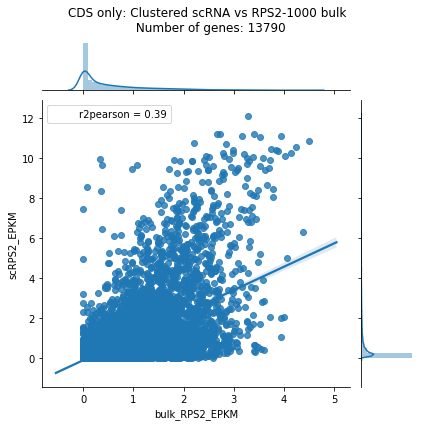

In [19]:
# Intersection of genes--filtered 
scRPS2_sorted_combined = pd.merge(scRPS2_sorted_cds['EPKM'], RPS2_0_cds_bulk['EPKM'], how='inner', left_index=True, right_index=True)

scRPS2_sorted_combined=scRPS2_sorted_combined.rename(columns={'EPKM_x':'scRPS2_EPKM', 
                                                              'EPKM_y':'bulk_RPS2_EPKM'
                                                             }
                                                    )

genes = len(scRPS2_sorted_combined)

g=sns.jointplot(data=np.log2(scRPS2_sorted_combined+1), y='scRPS2_EPKM', x='bulk_RPS2_EPKM', kind='reg', stat_func=r2pearson)
g.fig.suptitle('CDS only: Clustered scRNA vs RPS2-1000 bulk \n Number of genes: {}'.format(genes))
plt.subplots_adjust(top=0.9)
g.savefig(out_fig_dir+'new_sorted_scRNA_vs_bulk_RPS2-1000_cds_only.pdf', dpi=300, bbox_inches='tight')

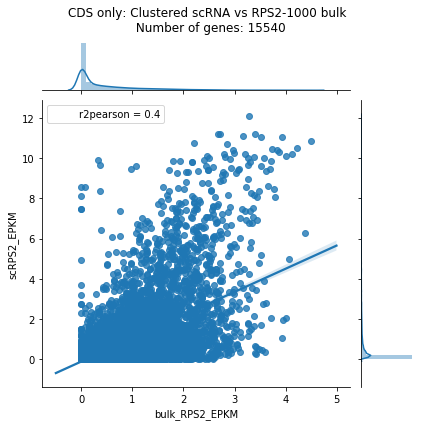

In [20]:
# Union of genes--filtered 
scRPS2_sorted_combined = pd.merge(scRPS2_sorted_cds['EPKM'], RPS2_0_cds_bulk['EPKM'], how='outer', left_index=True, right_index=True).fillna(0)

scRPS2_sorted_combined=scRPS2_sorted_combined.rename(columns={'EPKM_x':'scRPS2_EPKM', 
                                                              'EPKM_y':'bulk_RPS2_EPKM'
                                                             }
                                                    )
genes = len(scRPS2_sorted_combined)

g=sns.jointplot(data=np.log2(scRPS2_sorted_combined+1), y='scRPS2_EPKM', x='bulk_RPS2_EPKM', kind='reg', stat_func=r2pearson)
g.fig.suptitle('CDS only: Clustered scRNA vs RPS2-1000 bulk \n Number of genes: {}'.format(genes))
plt.subplots_adjust(top=0.9)
g.savefig(out_fig_dir+'new_sorted_scRNA_vs_bulk_RPS2-1000_cds_only_union.pdf', dpi=300, bbox_inches='tight')

## EPKM calculation for CDS + 3UTR

In [21]:
#sorted_name = '/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt.bam'

exon_sorted_counts = sc_cds_3utr_gene_counts[sorted_name]

In [22]:
# having to change the name of the length column to make the processing compatible
cds_3utr_gene_length = cds_3utr_gene_length.rename(columns={'Length':'length'})

In [23]:
# Calling it exon here, but really CDS/3UTR
exon_epkm_dict = defaultdict(lambda: 'None')

confs = [0, 0.5]

for conf in confs:
    # Reads in annotated bed files and returns dataframes with edits counts 
    exon_filtered = filter_for_conf(filter_cds_and_3utr(scRPS2_barcode_df), conf)
    exon_ecounts = per_gene_ecounts(exon_filtered)
        
    # merge with relevant counts files from featurecounts mapping--fill expressed genes with no edits with 0s  
    exon_ecounts = pd.merge(exon_ecounts, exon_sorted_counts, how='outer', left_index=True, right_index=True).fillna(0) # CDS counts only 
    exon_ecounts = exon_ecounts.rename(columns={'{}'.format(sorted_name):'counts'}) # rename sample counts columns
    exon_ecounts = pd.merge(exon_ecounts, cds_3utr_gene_length, how='outer', left_index=True, right_index=True).fillna(0) # CDS lengths only
    exon_ecounts = exon_ecounts.loc[exon_ecounts.length > 0] # For some reason some genes with edits but no gene annotation (remove)
    exon_ecounts = exon_ecounts[exon_ecounts['counts'] > 0] # this is an optional step if we want to filter out genes with no expression counts
        
    # addition of epkm values and addition of a pseudocount
    exon_ecounts = epkm(exon_ecounts)
    exon_ecounts['EPKM+ps'] = exon_ecounts['EPKM'] + 1
        
    # addition of TE values
    exon_ecounts = edits_te(exon_ecounts).fillna(0)
    name_string = 'RPS2-STAMP_possorted_Apo_filtered'+'_conf{}'.format(str(conf))
        
    exon_epkm_dict[name_string] = exon_ecounts

In [24]:
scRPS2_sorted = exon_epkm_dict['RPS2-STAMP_possorted_Apo_filtered_conf0']
scRPS2_sorted.head()

,edit_count,nonedit_count,counts,length,EPKM,EPKM+ps,te
ENSG00000000003,728.0,75389.0,5980,2091,4.895401,5.895401,58.220531
ENSG00000000005,0.0,0.0,8,1119,0.000000,1.000000,0.000000
ENSG00000000419,452.0,38988.0,4813,1150,5.526517,6.526517,81.662888
ENSG00000000457,6.0,143.0,419,6308,0.013374,1.013374,2.270103
ENSG00000000460,53.0,8164.0,1495,4213,0.176887,1.176887,8.414789


#### Lastly, do the same thing (CDS+3UTR) for the bulk sample (RPS2-1000)

In [25]:
RPS2_bulk_counts = cds_utr_bulk_counts['RPS2-1000']

In [26]:
# Need to clean this up and store in a function to prevent having to copy-and-paste it, but works for now
bulk_exon_epkm_dict = defaultdict(lambda: 'None')

confs = [0, 0.5]

for conf in confs:
    # Reads in annotated bed files and returns dataframes with edits counts 
    exon_filtered = filter_for_conf(filter_cds_and_3utr(RPS2_1000_bulk_df), conf)
    exon_ecounts = per_gene_ecounts(exon_filtered)
        
    # merge with relevant counts files from featurecounts mapping--fill expressed genes with no edits with 0s  
    exon_ecounts = pd.merge(exon_ecounts, RPS2_bulk_counts, how='outer', left_index=True, right_index=True).fillna(0) # CDS counts only 
    exon_ecounts = exon_ecounts.rename(columns={'RPS2-1000':'counts'}) # rename sample counts columns
    exon_ecounts = pd.merge(exon_ecounts, cds_3utr_gene_length, how='outer', left_index=True, right_index=True).fillna(0) # CDS lengths only
    exon_ecounts = exon_ecounts.loc[exon_ecounts.length > 0] # For some reason some genes with edits but no gene annotation (remove)
    exon_ecounts = exon_ecounts[exon_ecounts['counts'] > 0] # this is an optional step if we want to filter out genes with no expression counts
        
    # addition of epkm values and addition of a pseudocount
    exon_ecounts = epkm(exon_ecounts)
    exon_ecounts['EPKM+ps'] = exon_ecounts['EPKM'] + 1
        
    # addition of TE values
    exon_ecounts = edits_te(exon_ecounts).fillna(0)
    name_string = 'RPS2-STAMP-1000_bulk'+'_conf{}'.format(str(conf))
    
    
    bulk_exon_epkm_dict[name_string] = exon_ecounts

In [27]:
bulk_exon_epkm_dict.keys()

dict_keys(['RPS2-STAMP-1000_bulk_conf0', 'RPS2-STAMP-1000_bulk_conf0.5'])

In [28]:
RPS2_bulk = bulk_exon_epkm_dict['RPS2-STAMP-1000_bulk_conf0']
RPS2_bulk.head()

,edit_count,nonedit_count,counts,length,EPKM,EPKM+ps,te
ENSG00000000003,353.0,5275.0,3574.0,2091.0,5.543215,6.543215,47.235240
ENSG00000000419,80.0,1708.0,1894.0,1150.0,2.284195,3.284195,36.729259
ENSG00000000457,2.0,13.0,211.0,6308.0,0.010411,1.010411,1.502643
ENSG00000000460,66.0,783.0,914.0,4213.0,0.514391,1.514391,17.139821
ENSG00000000938,0.0,0.0,1.0,2437.0,0.000000,1.000000,0.000000


### Now compare the two scRNA datasets to bulk using the CDS+3UTR EPKM calculation

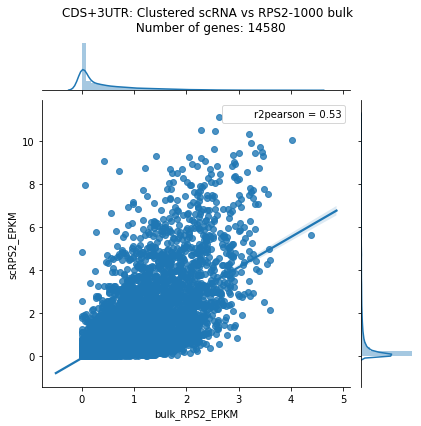

In [29]:
scRPS2_sorted_combined = pd.merge(scRPS2_sorted['EPKM'], RPS2_bulk['EPKM'], how='inner', left_index=True, right_index=True)

scRPS2_sorted_combined=scRPS2_sorted_combined.rename(columns={'EPKM_x':'scRPS2_EPKM', 
                                                              'EPKM_y':'bulk_RPS2_EPKM'
                                                             }
                                                    )

genes = len(scRPS2_sorted_combined)

g=sns.jointplot(data=np.log2(scRPS2_sorted_combined+1), y='scRPS2_EPKM', x='bulk_RPS2_EPKM', kind='reg', stat_func=r2pearson)
g.fig.suptitle('CDS+3UTR: Clustered scRNA vs RPS2-1000 bulk \n Number of genes: {}'.format(genes))
plt.subplots_adjust(top=0.9)
g.savefig(out_fig_dir+'new_sorted_scRNA_vs_bulk_RPS2-1000_cds_3utr.pdf', dpi=300, bbox_inches='tight')

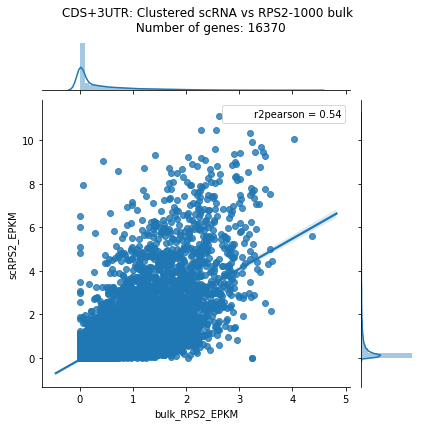

In [30]:
scRPS2_sorted_combined = pd.merge(scRPS2_sorted['EPKM'], RPS2_bulk['EPKM'], how='outer', left_index=True, right_index=True).fillna(0)

scRPS2_sorted_combined=scRPS2_sorted_combined.rename(columns={'EPKM_x':'scRPS2_EPKM', 
                                                              'EPKM_y':'bulk_RPS2_EPKM'
                                                             }
                                                    )
genes = len(scRPS2_sorted_combined)

g=sns.jointplot(data=np.log2(scRPS2_sorted_combined+1), y='scRPS2_EPKM', x='bulk_RPS2_EPKM', kind='reg', stat_func=r2pearson)
g.fig.suptitle('CDS+3UTR: Clustered scRNA vs RPS2-1000 bulk \n Number of genes: {}'.format(genes))
plt.subplots_adjust(top=0.9)
g.savefig(out_fig_dir+'new_sorted_scRNA_vs_bulk_RPS2-1000_cds_3utr_union.pdf', dpi=300, bbox_inches='tight')

## Comparison of CDS to CDS+3UTR EPKM

### Sorted

In [31]:
sorted_combined = pd.merge(scRPS2_sorted_cds['EPKM'], scRPS2_sorted['EPKM'], how='outer', left_index=True, right_index=True).fillna(0)
sorted_combined.rename(columns={'EPKM_x':'CDS_only',
                                'EPKM_y':'CDS_3UTR'}, inplace=True)

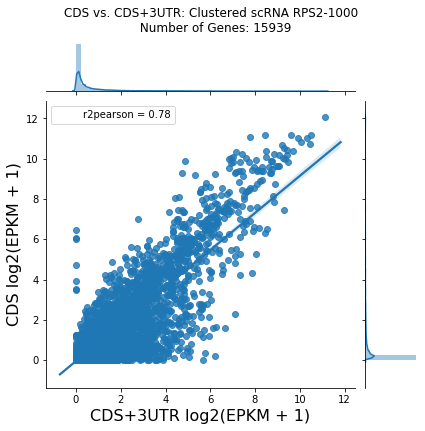

In [32]:
genes = len(sorted_combined)

g = sns.jointplot(data=np.log2(sorted_combined+1), y='CDS_only', x='CDS_3UTR', kind='reg', stat_func=r2pearson)
g.fig.suptitle('CDS vs. CDS+3UTR: Clustered scRNA RPS2-1000 \n Number of Genes: {}'.format(genes))
g.set_axis_labels('CDS+3UTR log2(EPKM + 1)', 'CDS log2(EPKM + 1)', fontsize=16)
plt.subplots_adjust(top=0.9)
g.savefig(out_fig_dir+'new_sorted_scRNA_RPS2-1000_cds_vs_cds_plus_3utr_epkm_all_genes.pdf', bbox_inches='tight', dpi=300)

# Other regional comparisons  

## Comparison to Ribosome datasets

### CDS-3UTR
- scRPS2_sorted

In [ ]:
scRPS2_sorted.head()

,edit_count,nonedit_count,counts,length,EPKM,EPKM+ps,te
ENSG00000000003,728.0,75389.0,5980,2091,4.895401,5.895401,58.220531
ENSG00000000005,0.0,0.0,8,1119,0.000000,1.000000,0.000000
ENSG00000000419,452.0,38988.0,4813,1150,5.526517,6.526517,81.662888
ENSG00000000457,6.0,143.0,419,6308,0.013374,1.013374,2.270103
ENSG00000000460,53.0,8164.0,1495,4213,0.176887,1.176887,8.414789


In [ ]:
riboseq1_file = os.path.join(ribo_dir, 'riboseq_pc_rpkm.txt')
riboseq2_file = os.path.join(ribo_dir, 'GSE94460_RPKM.txt')
ribolace_file = os.path.join(ribo_dir, 'ribolace_pc_rpkm.txt')
polysome_file = os.path.join(ribo_dir, 'fred_x3_polysome_RPKM.txt')

In [ ]:
polysome = pd.read_csv(polysome_file, sep='\t', index_col=0)
polysome.head()

,x3_input,x3_polysome,poly/input
Geneid,,,
ENSG00000262227,1.386483,0.000000,0.000000
ENSG00000273243,1.615120,0.000000,0.000000
ENSG00000254207,1.450542,0.215213,0.148368
ENSG00000230359,1.473046,0.542613,0.368361
ENSG00000105880,1.390836,0.430654,0.309637


In [ ]:
polysome['norm_ps'] = (polysome['x3_polysome']+1) / (polysome['x3_input'] +1)

## Un-normalized polysome 

#### Sorted 

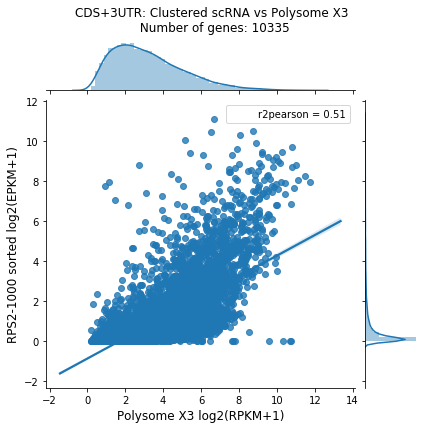

In [ ]:
scRPS2_combined = pd.merge(scRPS2_sorted['EPKM'], polysome['x3_polysome'], how='inner', left_index=True, right_index=True)

scRPS2_combined=scRPS2_combined.rename(columns={'EPKM':'scRPS2_EPKM', 
                                                              'x3_polysome':'Polysome RPKM'
                                                             }
                                                    )

genes = len(scRPS2_combined)

g=sns.jointplot(data=np.log2(scRPS2_combined+1), y='scRPS2_EPKM', x='Polysome RPKM', kind='reg', stat_func=r2pearson)
g.fig.suptitle('CDS+3UTR: Clustered scRNA vs Polysome X3 \n Number of genes: {}'.format(genes))
plt.subplots_adjust(top=0.9)
g.set_axis_labels('Polysome X3 log2(RPKM+1)', 'RPS2-1000 sorted log2(EPKM+1)', fontsize=12)
g.savefig(out_fig_dir+'new_sorted_scRNA_RPS2-1000_vs_polysome_cds_3utr.pdf', dpi=300, bbox_inches='tight')

In [ ]:
scRPS2_combined = pd.merge(scRPS2_sorted['EPKM'], polysome['x3_polysome'], how='outer', left_index=True, right_index=True).fillna(0)

scRPS2_combined=scRPS2_combined.rename(columns={'EPKM':'scRPS2_EPKM', 
                                                              'x3_polysome':'Polysome RPKM'
                                                             }
                                                    )

genes = len(scRPS2_combined)

g=sns.jointplot(data=np.log2(scRPS2_combined+1), y='scRPS2_EPKM', x='Polysome RPKM', kind='reg', stat_func=r2pearson)
g.fig.suptitle('CDS+3UTR: Clustered scRNA vs Polysome X3 \n Number of genes: {}'.format(genes))
plt.subplots_adjust(top=0.9)
g.set_axis_labels('Polysome X3 log2(RPKM+1)', 'RPS2-1000 sorted log2(EPKM+1)', fontsize=12)
g.savefig(out_fig_dir+'new_sorted_scRNA_RPS2-1000_vs_polysome_cds_3utr_union.pdf', dpi=300, bbox_inches='tight')

## Normalized polysome 

#### Sorted 

In [ ]:
# CDS+3UTR
scRPS2_combined = pd.merge(scRPS2_sorted['EPKM']+1, polysome['norm_ps'], how='inner', left_index=True, right_index=True)

scRPS2_combined=scRPS2_combined.rename(columns={'EPKM':'scRPS2_EPKM', 
                                                              'norm_ps':'Polysome/Input'
                                                             }
                                                    )

genes = len(scRPS2_combined)

g=sns.jointplot(data=np.log2(scRPS2_combined), y='scRPS2_EPKM', x='Polysome/Input', kind='reg', stat_func=r2pearson)
g.fig.suptitle('CDS+3UTR: Clustered scRNA vs Polysome normalized \n Number of genes: {}'.format(genes))
plt.subplots_adjust(top=0.9)
g.set_axis_labels('log2(Polysome/Input)', 'RPS2-1000 sorted log2(EPKM+1)', fontsize=12)
g.savefig(out_fig_dir+'new_sorted_scRNA_RPS2-1000_vs_polysome_norm_cds_3utr.pdf', dpi=300, bbox_inches='tight')

## Ribo-seq (dataset #2)

In [ ]:
riboseq_rpkm = pd.read_csv(riboseq2_file, sep='\t', index_col=0)
riboseq_rpkm.head()

In [ ]:
# CDS+3UTR
scRPS2_combined = pd.merge(scRPS2_sorted['EPKM'], riboseq_rpkm['mean_rpkm'], how='inner', left_index=True, right_index=True)

scRPS2_combined=scRPS2_combined.rename(columns={'EPKM':'scRPS2_EPKM', 
                                                              'mean_rpkm':'riboseq_rpkm'
                                                             }
                                                    )

genes = len(scRPS2_combined)

g=sns.jointplot(data=np.log2(scRPS2_combined+1), y='scRPS2_EPKM', x='riboseq_rpkm', kind='reg', stat_func=r2pearson)
g.fig.suptitle('CDS+3UTR: Clustered scRNA vs Ribo-seq \n Number of genes: {}'.format(genes))
plt.subplots_adjust(top=0.9)
g.set_axis_labels('Ribo-seq log2(RPKM+1)', 'RPS2-1000 sorted log2(EPKM+1)', fontsize=12)
g.savefig(out_fig_dir+'new_sorted_scRNA_RPS2-1000_vs_riboseq2_cds_3utr.pdf', dpi=300, bbox_inches='tight')

In [ ]:
scRPS2_combined.head()

In [ ]:
# CDS+3UTR --> union
scRPS2_combined = pd.merge(scRPS2_sorted['EPKM'], riboseq_rpkm['mean_rpkm'], how='outer', left_index=True, right_index=True).fillna(0)

scRPS2_combined=scRPS2_combined.rename(columns={'EPKM':'scRPS2_EPKM', 
                                                              'mean_rpkm':'riboseq_rpkm'
                                                             }
                                                    )

genes = len(scRPS2_combined)

g=sns.jointplot(data=np.log2(scRPS2_combined+1), y='scRPS2_EPKM', x='riboseq_rpkm', kind='reg', stat_func=r2pearson)
g.fig.suptitle('CDS+3UTR: Clustered scRNA vs Ribo-seq \n Number of genes: {}'.format(genes))
plt.subplots_adjust(top=0.9)
g.set_axis_labels('Ribo-seq log2(RPKM+1)', 'RPS2-1000 sorted log2(EPKM+1)', fontsize=12)
g.savefig(out_fig_dir+'new_sorted_scRNA_RPS2-1000_vs_riboseq2_cds_3utr_union.pdf', dpi=300, bbox_inches='tight')

### Comparison of bulk and single cell to polysome inputs

In [ ]:
RPS2_bulk['RPKM'] = RPS2_bulk['counts'].div(RPS2_bulk.counts.sum() / 10**6, axis=0).div(RPS2_bulk['length'] / 10**3)
scRPS2_sorted['RPKM'] = scRPS2_sorted['counts'].div(scRPS2_sorted.counts.sum() / 10**6, axis=0).div(scRPS2_sorted['length'] / 10**3)

In [ ]:
polysome.head()

In [ ]:
scRPS2_combined = pd.merge(scRPS2_sorted['EPKM'], polysome['x3_input'], how='outer', left_index=True, right_index=True).fillna(0)

scRPS2_combined=scRPS2_combined.rename(columns={'EPKM':'scRPS2_EPKM', 
                                                              'x3_input':'Polysome Input RPKM'
                                                             }
                                                    )

genes = len(scRPS2_combined)

g=sns.jointplot(data=np.log2(scRPS2_combined+1), y='scRPS2_EPKM', x='Polysome Input RPKM', kind='reg', stat_func=r2pearson)
g.fig.suptitle('CDS+3UTR: Clustered scRNA vs Polysome X3 Input \n Number of genes: {}'.format(genes))
plt.subplots_adjust(top=0.9)
g.set_axis_labels('Polysome Input X3 log2(RPKM+1)', 'RPS2-1000 sorted log2(EPKM+1)', fontsize=12)
g.savefig(out_fig_dir+'new_sorted_scRNA_vs_polysome_input_cds_3utr_union.pdf', dpi=300, bbox_inches='tight')

In [ ]:
scRPS2_combined = pd.merge(scRPS2_sorted['EPKM'], polysome['x3_input'], how='inner', left_index=True, right_index=True)

scRPS2_combined=scRPS2_combined.rename(columns={'EPKM':'scRPS2_EPKM', 
                                                              'x3_input':'Polysome Input RPKM'
                                                             }
                                                    )

genes = len(scRPS2_combined)

g=sns.jointplot(data=np.log2(scRPS2_combined+1), y='scRPS2_EPKM', x='Polysome Input RPKM', kind='reg', stat_func=r2pearson)
g.fig.suptitle('CDS+3UTR: Clustered scRNA vs Polysome X3 Input \n Number of genes: {}'.format(genes))
plt.subplots_adjust(top=0.9)
g.set_axis_labels('Polysome Input X3 log2(RPKM+1)', 'RPS2-1000 sorted log2(EPKM+1)', fontsize=12)
g.savefig(out_fig_dir+'new_sorted_scRNA_vs_polysome_input_cds_3utr.pdf', dpi=300, bbox_inches='tight')

In [ ]:
scRPS2_combined = pd.merge(scRPS2_sorted['RPKM'], polysome['x3_input'], how='outer', left_index=True, right_index=True).fillna(0)

scRPS2_combined=scRPS2_combined.rename(columns={'RPKM':'scRPS2_RPKM', 
                                                              'x3_input':'Polysome Input RPKM'
                                                             }
                                                    )

genes = len(scRPS2_combined)

g=sns.jointplot(data=np.log2(scRPS2_combined+1), y='scRPS2_RPKM', x='Polysome Input RPKM', kind='reg', stat_func=r2pearson)
g.fig.suptitle('CDS+3UTR: Clustered scRNA vs Polysome X3 Input \n Number of genes: {}'.format(genes))
plt.subplots_adjust(top=0.9)
g.set_axis_labels('Polysome Input X3 log2(RPKM+1)', 'RPS2-1000 sorted log2(RPKM+1)', fontsize=12)
g.savefig(out_fig_dir+'new_sorted_scRNA_RPKM_vs_polysome_input_cds_3utr_union.pdf', dpi=300, bbox_inches='tight')

In [ ]:
scRPS2_combined = pd.merge(scRPS2_sorted['RPKM'], polysome['x3_input'], how='inner', left_index=True, right_index=True)

scRPS2_combined=scRPS2_combined.rename(columns={'RPKM':'scRPS2_RPKM', 
                                                              'x3_input':'Polysome Input RPKM'
                                                             }
                                                    )

genes = len(scRPS2_combined)

g=sns.jointplot(data=np.log2(scRPS2_combined+1), y='scRPS2_RPKM', x='Polysome Input RPKM', kind='reg', stat_func=r2pearson)
g.fig.suptitle('CDS+3UTR: Clustered scRNA vs Polysome X3 Input \n Number of genes: {}'.format(genes))
plt.subplots_adjust(top=0.9)
g.set_axis_labels('Polysome Input X3 log2(RPKM+1)', 'RPS2-1000 sorted log2(RPKM+1)', fontsize=12)
g.savefig(out_fig_dir+'new_sorted_scRNA_RPKM_vs_polysome_input_cds_3utr.pdf', dpi=300, bbox_inches='tight')